In [1]:
# Kütüphaneler projeye eklendi
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
# Google Drive'a bağlanma
drive.mount('/content/drive')

# Çalışma dizini ayarlama
os.chdir('/content/drive/My Drive/deneme')
!pwd

Mounted at /content/drive
/content/drive/My Drive/deneme


In [3]:
# Veri seti projeye eklendi ve tablo ekrana yazdırıldı
data = pd.read_csv('veri-seti.csv')
data.head(2)

,Country,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,0,0,0,4.084,4.585,5.971,7.309,8.399,9.892,...,21.555,24.304,0,0,0,0,0,0,0,0
1,Albania,3.444,3.695,4.096,4.456,5.6,7.452,8.376,9.133,10.163,...,14.91,16.053,11.591,12.204,13.214,14.341,15.553,16.996,16.77,18.012


Bir ülke ismi girin: Afghanistan
Hangi yılın tahmini verisini istiyorsunuz: 2023
Kayıp veri sayısı: 10
Eğitim verisi MSE: 0.687634191773554, R^2: 0.1708983192795177
Test verisi MSE: 2.190376036290559, R^2: -0.3919258450514931
Çapraz doğrulama R^2 skoru: -13.606229848344222


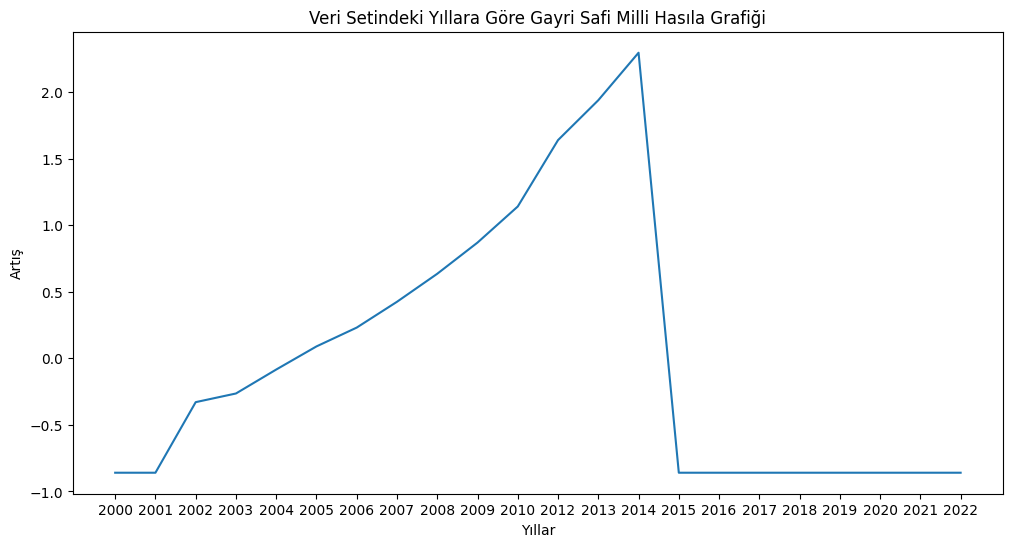

2023 yılı için Afghanistan'nın tahmini gayri safi milli hasılası: 1.5736484751204731 Milyar


In [4]:
# Veri setini yükleme
veri_seti = pd.read_csv('veri-seti.csv')

# Kullanıcıdan ülke ismi alınıyor
ulke_adi = input("Bir ülke ismi girin: ")


# Veri setinde bu ülkenin olup olmadığını kontrol etme
if ulke_adi not in veri_seti["Country"].unique():
    print(f"{ulke_adi} isimli bir ülke veri setinde bulunamadı!")
else:
    # Kullanıcıdan tahmin edilmek istenen yıl alınıyor
    istenilen_yil = input("Hangi yılın tahmini verisini istiyorsunuz: ")

    # Kullanıcıdan alınan yılı int'e çevirme
    yil = int(istenilen_yil)

    # Girilen ülkenin verilerini seçme
    secilen_ulke_data = veri_seti[veri_seti['Country'] == ulke_adi].iloc[0]

    # Veri setindeki yılları ve değerleri ayırma
    yillar = secilen_ulke_data.keys()[2:]
    gsh_degerler = secilen_ulke_data.values[2:].astype(str)

    # Değerlerdeki virgülü kaldırma ve float dönüşümü
    gsh_degerler = np.array([float(deger.replace(',', '')) for deger in gsh_degerler])

    # Veri ön işleme
    # Kayıp veri analizi
    eksik_veri_sayisi = len(gsh_degerler[gsh_degerler == 0])
    print(f"Kayıp veri sayısı: {eksik_veri_sayisi}")

    # Eksik değerleri tamamlama
    eksik_indeksler = np.where(gsh_degerler == 0)[0]
    for indeks in eksik_indeksler:
        onceki_deger_indeks = indeks - 1
        while onceki_deger_indeks >= 0 and gsh_degerler[onceki_deger_indeks] == 0:
            onceki_deger_indeks -= 1
        sonraki_deger_indeks = indeks + 1
        while sonraki_deger_indeks < len(gsh_degerler) and gsh_degerler[sonraki_deger_indeks] == 0:
            sonraki_deger_indeks += 1

        if onceki_deger_indeks >= 0 and sonraki_deger_indeks < len(gsh_degerler):
            onceki_deger = gsh_degerler[onceki_deger_indeks]
            sonraki_deger = gsh_degerler[sonraki_deger_indeks]
            eksik_veri = (onceki_deger + sonraki_deger) / 2
            gsh_degerler[indeks] = eksik_veri

    # Verileri ölçeklendirme (standartlaştırma veya normalizasyon)
    scaler = StandardScaler()  # veya MinMaxScaler()
    gsh_degerler_scaled = scaler.fit_transform(gsh_degerler.reshape(-1, 1))

    # Veri setini özellikler (X) ve hedef değişken (y) olarak ayırma
    X = np.array(yillar).reshape(-1, 1)
    y = gsh_degerler_scaled
    
    # Eğitim ve test verisi ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Regresyon modelini eğitme
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    # Tahmin yapma
    tahmin = scaler.inverse_transform(reg.predict(np.array([[yil]])))

    # Model değerlendirmesi
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print(f"Eğitim verisi MSE: {mse_train}, R^2: {r2_train}")
    print(f"Test verisi MSE: {mse_test}, R^2: {r2_test}")

    # Çapraz doğrulama (Cross-Validation)
    scores = cross_val_score(reg, np.array(yillar).reshape(-1, 1), gsh_degerler_scaled, cv=5, scoring='r2')
    print(f"Çapraz doğrulama R^2 skoru: {np.mean(scores)}")

    # Çizgi grafiği oluşturma ve boyutlarını ayarlama
    fig = plt.figure(figsize=(12, 6))
    plt.plot(yillar, gsh_degerler_scaled)

    # Eksenleri ve grafiği düzenleme
    plt.title('Veri Setindeki Yıllara Göre Gayri Safi Milli Hasıla Grafiği')
    plt.xlabel('Yıllar')
    plt.ylabel('Artış')

    # Grafiği gösterme
    plt.show()

    # Tahmini değeri kullanıcıya gösterme
    print(f"{yil} yılı için {ulke_adi}'nın tahmini gayri safi milli hasılası: {tahmin[0][0]} Milyar")

